In [ ]:
#Installing astroquery library as it doesnt exist natively in google colab
!pip install astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.3 MB/s eta 0:00:00


In [ ]:
#Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery import mast
import seaborn as sns
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler

In [ ]:
#Getting data for analysis
TIC_data = mast.Catalogs.query_object("M67", radius = 1.0, catalog = "TIC")
CTL_data = mast.Catalogs.query_object("M67", radius = 1.0, catalog = "CTL")

m67 = SkyCoord("08h51m18s +11d48m00s")
#radius = 1*u.deg

hosts = NasaExoplanetArchive.query_region(
            table="pscomppars",
            coordinates=m67,
            radius=1.0*u.deg,
            select="hostname,ra,dec,pl_letter,tic_id")

In [ ]:
#Converting data in astropy tables to dataframes for easy processing, analysis, visualisation and modelling
TIC_df = TIC_data.to_pandas()
CTL_df = CTL_data.to_pandas()
hosts_df = hosts.to_pandas()
TIC_df.set_index("ID", inplace=True)
CTL_df.set_index("ID", inplace=True)
hosts_df.set_index("tic_id", inplace=True)

In [ ]:
#Some required pre processing
hosts_df.index = hosts_df.index.str.replace('TIC ', '', regex = False)
TIC_df.index = TIC_df.index.astype(int)
CTL_df.index = CTL_df.index.astype(int)
hosts_df.index = hosts_df.index.astype(int)

- The TIC and CTL catalogs have 125 features for a star, carrying varied information for deep scientific analysis.
- But all of these stellar parameters do not highly influence the chances of it hosting a planet in its neighbourhood
- After an extensive literature review, I choose the following columns (next code cell) for further analysis (a summary is given as follows for each column and its relevance):

| Column Name      | Description & Units                                                               | Relevance to Analysis                       |
|------------------|-----------------------------------------------------------------------------------|---------------------------------------------|
| **ra, dec**      | Right Ascension and Declination (ICRS, J2000), in degrees                         | Essential for sky plots and cross-matching  |
| **Tmag**         | TESS Magnitude (wide bandpass, red-optical)                                       | CTL selection is based on Tmag              |
| **GAIAmag**      | Gaia G-band magnitude                                                             | For precise photometry and quality check    |
| **objType**      | Object classification (STAR or EXTENDED)                                          | Useful for identifying stars                |
| **plx**          | Parallax (mas)                                                                    | Used to calculate distance                  |
| **e_plx**        | Parallax uncertainty                                                              | Filter out unreliable distances             |
| **d**            | Distance (parsec)                                                                 | Derived from parallax                       |
| **e_d**          | Distance uncertainty                                                              | Shows data quality                          |
| **Teff**         | Effective temperature (Kelvin)                                                    | Key stellar parameter                       |
| **e_Teff**       | Uncertainty in Teff                                                               | Shows data reliability                      |
| **rad**          | Stellar radius (solar radii)                                                      | Smaller stars better for transits           |
| **logg**         | Surface gravity (log10[cm/s²])                                                    | distinguishes dwarfs/giants                 |
| **mass**         | Stellar mass (solar masses)                                                       | Important for stellar/planet context        |
| **e_rad, e_logg, e_mass**| Uncertainty in quantities                                                 | data reliability                            |
| **priority**     | CTL prioritization metric (0–1)                                                   | Important for CTL analysis                  |
| **disposition**  | Reason for CTL inclusion (CTL, TFA, etc.)                                         | Distinguish algorithmic vs. manual          |
| **e_Tmag, e_GAIAmag** | Uncertainties in magnitudes                                             | Filter poor photometry                      |

In [ ]:
useful_columns = [
    'ra', 'dec', 'objType', 'plx', 'e_plx', 'Tmag', 'GAIAmag', 'e_Tmag', 'e_GAIAmag', 'Teff', 'rad', 'logg',
    'mass', 'd', 'e_Teff', 'e_rad', 'e_logg', 'e_mass' ,'e_d', 'priority', 'disposition'
]

In [ ]:
#further processing
TIC_analysis = TIC_df[useful_columns].copy()
CTL_analysis = CTL_df[useful_columns].copy()
TIC_analysis = TIC_analysis[TIC_analysis['objType'] == 'STAR']
CTL_analysis = CTL_analysis[CTL_analysis['objType'] == 'STAR']
TIC_analysis = TIC_analysis[pd.isna(TIC_analysis['disposition'])]
CTL_analysis = CTL_analysis[pd.isna(CTL_analysis['disposition'])]
TIC_analysis.drop(columns=['objType', 'disposition', 'priority'], inplace=True)
CTL_analysis.drop(columns=['objType', 'disposition', 'priority'], inplace=True)
TIC_analysis['In_CTL'] = TIC_analysis.index.isin(CTL_analysis.index).astype(int)
TIC_analysis['confirmed'] = TIC_analysis.index.isin(hosts_df.index).astype(int)

In [ ]:
CTL_neg_Conf_neg = TIC_analysis[((TIC_analysis['In_CTL'] == 0) & (TIC_analysis['confirmed'] == 0))].copy()
CTL_pos_Conf_neg = TIC_analysis[((TIC_analysis['In_CTL'] == 1) & (TIC_analysis['confirmed'] == 0))].copy()
CTL_neg_Conf_pos = TIC_analysis[((TIC_analysis['In_CTL'] == 0) & (TIC_analysis['confirmed'] == 1))].copy()
CTL_pos_Conf_pos = TIC_analysis[((TIC_analysis['In_CTL'] == 1) & (TIC_analysis['confirmed'] == 1))].copy()

# Plots for understanding the data

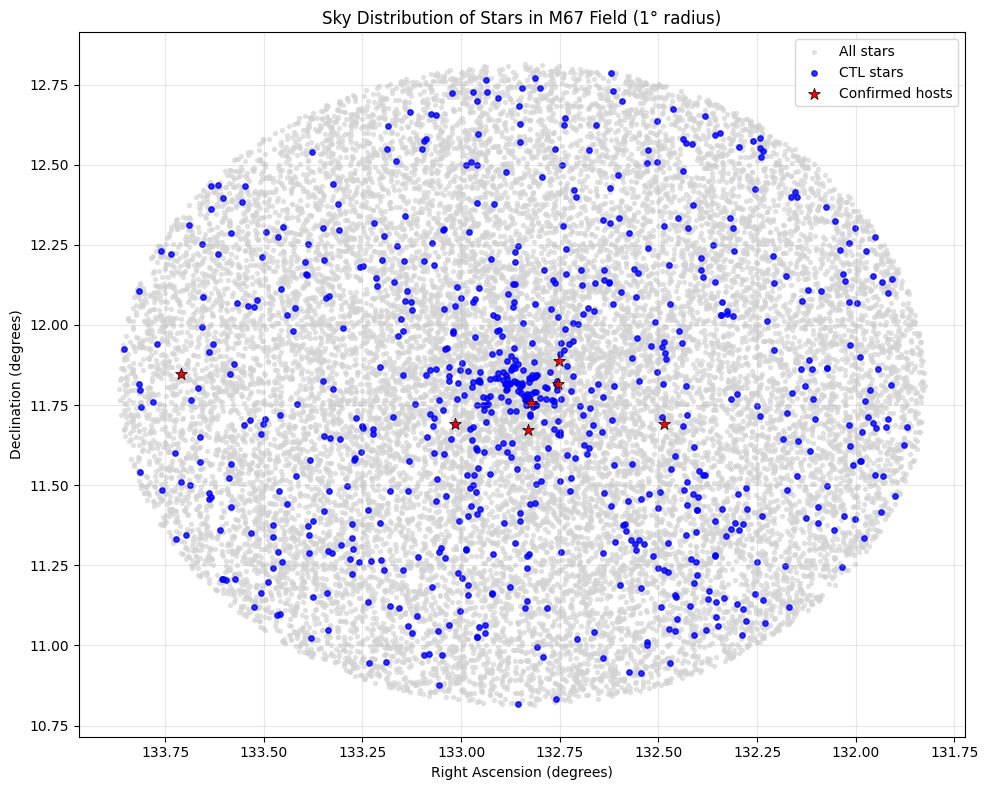

In [ ]:
# Set style for better-looking plots
plt.style.use('default')
sns.set_palette("husl")

# Convert integer flags to boolean for easier filtering
In_CTL_bool = TIC_analysis['In_CTL'] == 1
confirmed_bool = TIC_analysis['confirmed'] == 1

# 1. Sky Map: Spatial Distribution
plt.figure(figsize=(10, 8))
plt.scatter(TIC_analysis['ra'], TIC_analysis['dec'], c='lightgray', s=8, alpha=0.6, label='All stars')
plt.scatter(TIC_analysis.loc[In_CTL_bool, 'ra'], TIC_analysis.loc[In_CTL_bool, 'dec'],
           c='blue', s=15, alpha=0.8, label='CTL stars')
plt.scatter(TIC_analysis.loc[confirmed_bool, 'ra'], TIC_analysis.loc[confirmed_bool, 'dec'],
           c='red', s=80, marker='*', edgecolors='black', linewidth=0.5,
           label='Confirmed hosts')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('Sky Distribution of Stars in M67 Field (1° radius)')
plt.legend()
plt.gca().invert_xaxis()  # RA increases to the left in astronomy
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

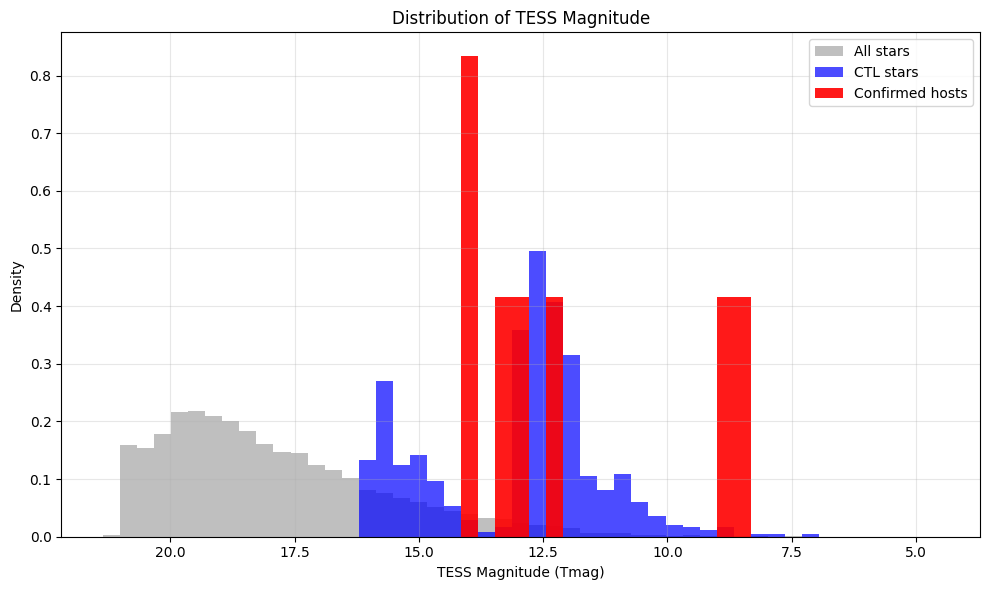

In [ ]:
# 2. TESS Magnitude Distribution
plt.figure(figsize=(10, 6))
bins = np.linspace(TIC_analysis['Tmag'].min(), TIC_analysis['Tmag'].max(), 50)
plt.hist(TIC_analysis['Tmag'], bins=bins, alpha=0.5, color='gray', label='All stars', density=True)
plt.hist(TIC_analysis.loc[In_CTL_bool, 'Tmag'], bins=bins, alpha=0.7, color='blue',
         label='CTL stars', density=True)
plt.hist(TIC_analysis.loc[confirmed_bool, 'Tmag'], bins=bins, alpha=0.9, color='red',
         label='Confirmed hosts', density=True)
plt.xlabel('TESS Magnitude (Tmag)')
plt.ylabel('Density')
plt.title('Distribution of TESS Magnitude')
plt.legend()
plt.gca().invert_xaxis()  # Brighter stars (lower mag) on right
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

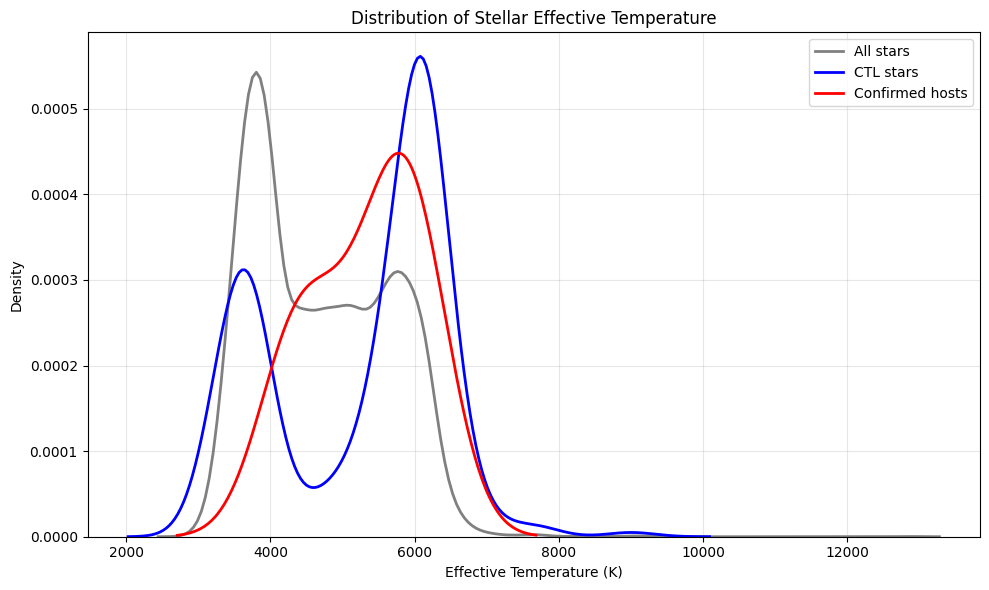

In [ ]:
# 3. Effective Temperature Distribution
plt.figure(figsize=(10, 6))
# Removing NaN values for cleaner plotting
teff_clean = TIC_analysis['Teff'].dropna()
teff_ctl = TIC_analysis.loc[In_CTL_bool, 'Teff'].dropna()
teff_confirmed = TIC_analysis.loc[confirmed_bool, 'Teff'].dropna()

sns.kdeplot(teff_clean, label='All stars', color='gray', linewidth=2)
sns.kdeplot(teff_ctl, label='CTL stars', color='blue', linewidth=2)
if len(teff_confirmed) > 0:
    sns.kdeplot(teff_confirmed, label='Confirmed hosts', color='red', linewidth=2)
plt.xlabel('Effective Temperature (K)')
plt.ylabel('Density')
plt.title('Distribution of Stellar Effective Temperature')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

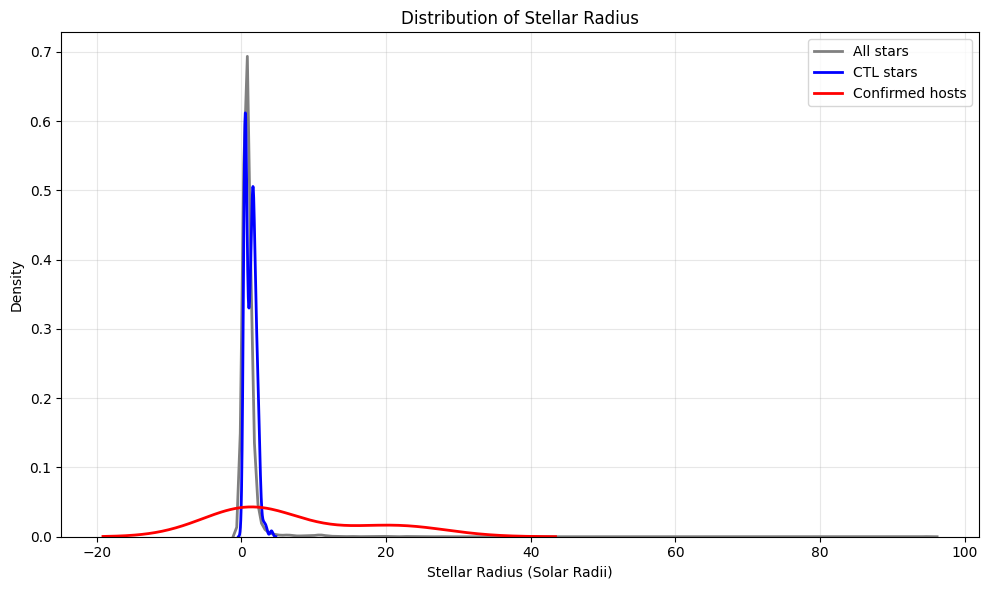

In [ ]:
# 4. Stellar Radius Distribution
plt.figure(figsize=(10, 6))
rad_clean = TIC_analysis['rad'].dropna()
rad_ctl = TIC_analysis.loc[In_CTL_bool, 'rad'].dropna()
rad_confirmed = TIC_analysis.loc[confirmed_bool, 'rad'].dropna()

sns.kdeplot(rad_clean, label='All stars', color='gray', linewidth=2)
sns.kdeplot(rad_ctl, label='CTL stars', color='blue', linewidth=2)
if len(rad_confirmed) > 0:
    sns.kdeplot(rad_confirmed, label='Confirmed hosts', color='red', linewidth=2)
plt.xlabel('Stellar Radius (Solar Radii)')
plt.ylabel('Density')
plt.title('Distribution of Stellar Radius')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

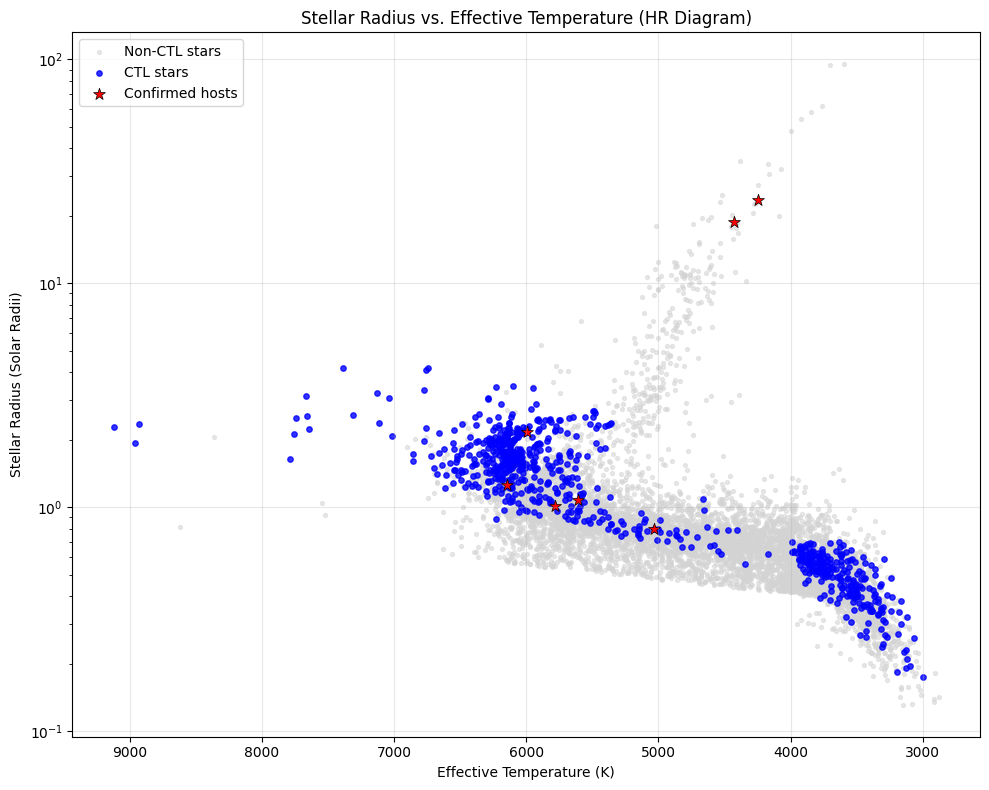

In [ ]:
# 5. HR Diagram Approximation (Radius vs. Temperature)
plt.figure(figsize=(10, 8))
# Plot non-CTL stars first (background)
non_ctl_mask = ~In_CTL_bool
plt.scatter(TIC_analysis.loc[non_ctl_mask, 'Teff'], TIC_analysis.loc[non_ctl_mask, 'rad'],
           c='lightgray', s=8, alpha=0.5, label='Non-CTL stars')
plt.scatter(TIC_analysis.loc[In_CTL_bool, 'Teff'], TIC_analysis.loc[In_CTL_bool, 'rad'],
           c='blue', s=15, alpha=0.8, label='CTL stars')
plt.scatter(TIC_analysis.loc[confirmed_bool, 'Teff'], TIC_analysis.loc[confirmed_bool, 'rad'],
           c='red', s=80, marker='*', edgecolors='black', linewidth=0.5,
           label='Confirmed hosts')
plt.xlabel('Effective Temperature (K)')
plt.ylabel('Stellar Radius (Solar Radii)')
plt.title('Stellar Radius vs. Effective Temperature (HR Diagram)')
plt.legend()
plt.gca().invert_xaxis()  # Hotter stars on left (astronomical convention)
plt.yscale('log')  # Radius spans orders of magnitude
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

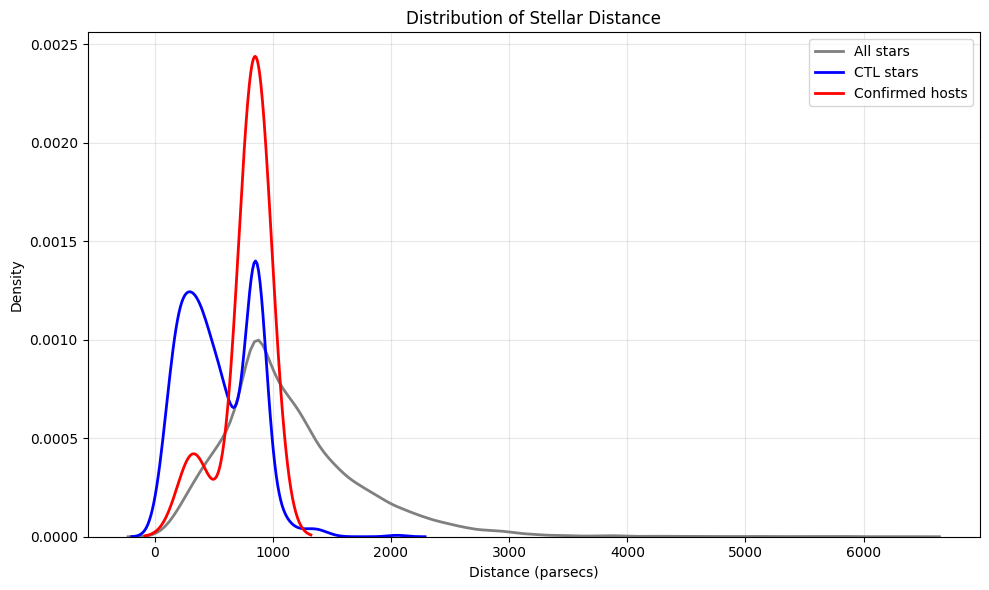

In [ ]:
# 6. Distance Distribution
plt.figure(figsize=(10, 6))
d_clean = TIC_analysis['d'].dropna()
d_ctl = TIC_analysis.loc[In_CTL_bool, 'd'].dropna()
d_confirmed = TIC_analysis.loc[confirmed_bool, 'd'].dropna()

sns.kdeplot(d_clean, label='All stars', color='gray', linewidth=2)
sns.kdeplot(d_ctl, label='CTL stars', color='blue', linewidth=2)
if len(d_confirmed) > 0:
    sns.kdeplot(d_confirmed, label='Confirmed hosts', color='red', linewidth=2)
plt.xlabel('Distance (parsecs)')
plt.ylabel('Density')
plt.title('Distribution of Stellar Distance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

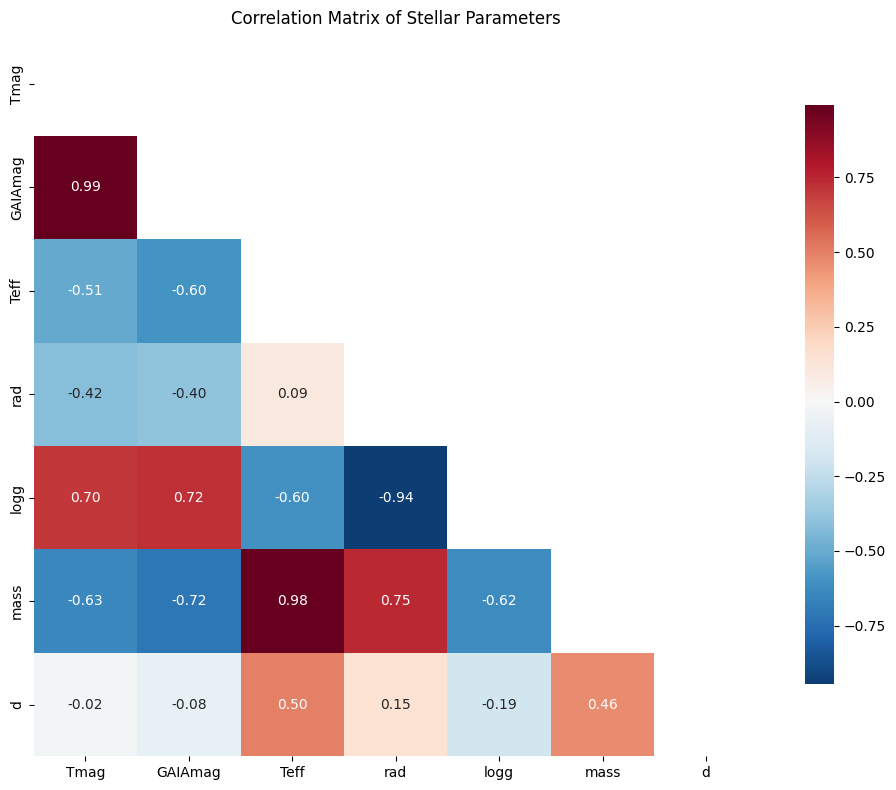

In [ ]:
# 7. Correlation Matrix
numeric_cols = ['Tmag', 'GAIAmag', 'Teff', 'rad', 'logg', 'mass', 'd']
# Remove columns with too many NaN values
available_cols = [col for col in numeric_cols if col in TIC_analysis.columns and TIC_analysis[col].notna().sum() > 10]

plt.figure(figsize=(10, 8))
corr_matrix = TIC_analysis[available_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Show only lower triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Stellar Parameters')
plt.tight_layout()
plt.show()


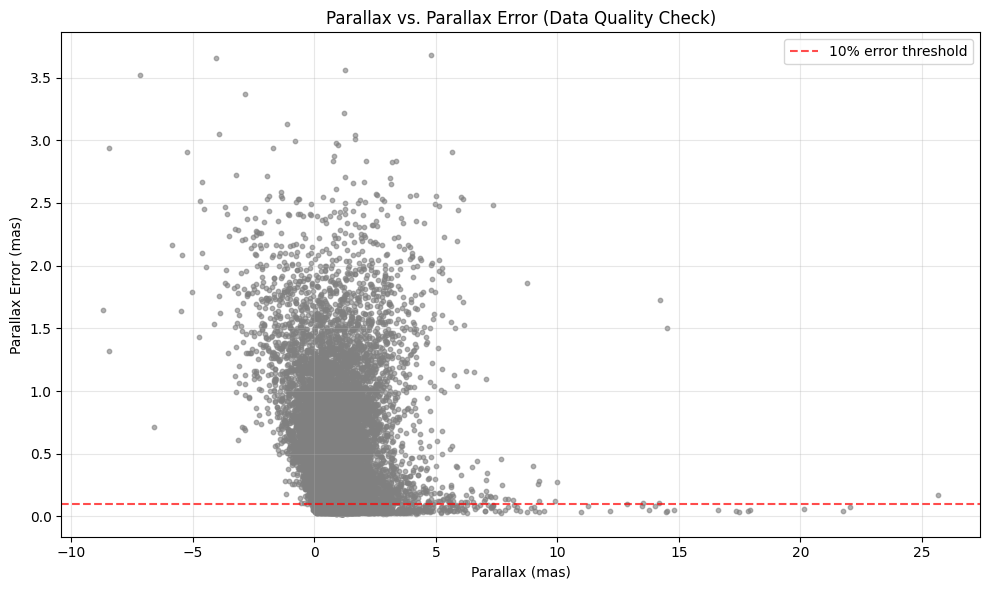

In [ ]:
# 8. Parallax Quality Check
plt.figure(figsize=(10, 6))
plt.scatter(TIC_analysis['plx'], TIC_analysis['e_plx'], c='gray', s=10, alpha=0.6)
plt.axhline(y=0.1, color='red', linestyle='--', alpha=0.7,
           label='10% error threshold')
plt.xlabel('Parallax (mas)')
plt.ylabel('Parallax Error (mas)')
plt.title('Parallax vs. Parallax Error (Data Quality Check)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 9. Summary Statistics Table
print("=== SUMMARY STATISTICS ===")
print(f"Total stars in field: {len(TIC_analysis)}")
print(f"Stars in CTL: {In_CTL_bool.sum()}")
print(f"Confirmed exoplanet hosts: {confirmed_bool.sum()}")
print(f"Confirmed hosts also in CTL: {(In_CTL_bool & confirmed_bool).sum()}")
print(f"CTL selection rate: {In_CTL_bool.mean():.1%}")
print(f"Host detection rate in field: {confirmed_bool.mean():.3%}")


=== SUMMARY STATISTICS ===
Total stars in field: 19850
Stars in CTL: 723
Confirmed exoplanet hosts: 7
Confirmed hosts also in CTL: 2
CTL selection rate: 3.6%
Host detection rate in field: 0.035%


/tmp/ipython-input-28-1486852363.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_box, labels=labels_for_box)


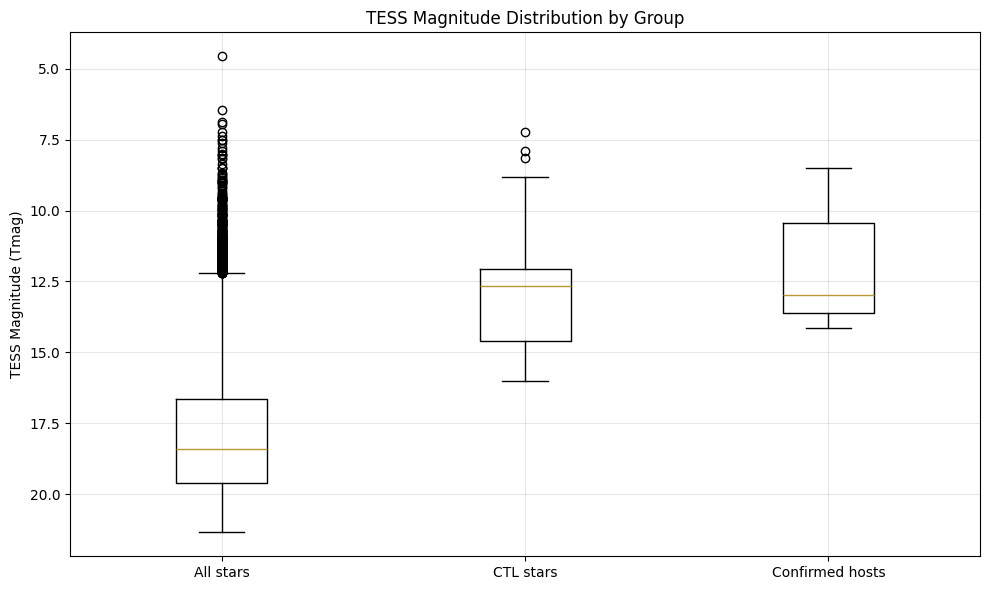

In [ ]:
# 10. Magnitude comparison boxplot
plt.figure(figsize=(10, 6))
data_for_box = []
labels_for_box = []

data_for_box.append(TIC_analysis['Tmag'].dropna())
labels_for_box.append('All stars')

data_for_box.append(TIC_analysis.loc[In_CTL_bool, 'Tmag'].dropna())
labels_for_box.append('CTL stars')

if confirmed_bool.sum() > 0:
    data_for_box.append(TIC_analysis.loc[confirmed_bool, 'Tmag'].dropna())
    labels_for_box.append('Confirmed hosts')

plt.boxplot(data_for_box, labels=labels_for_box)
plt.ylabel('TESS Magnitude (Tmag)')
plt.title('TESS Magnitude Distribution by Group')
plt.gca().invert_yaxis()  # Brighter stars (lower mag) at top
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Modelling

In [ ]:
TIC_analysis.isnull().sum()

,0
ra,0
dec,0
plx,4283
e_plx,4283
Tmag,0
GAIAmag,529
e_Tmag,6
e_GAIAmag,529
Teff,8680
rad,11903


In [ ]:
# Categorize features by data quality
high_quality_features = ['ra', 'dec', 'Tmag', 'e_Tmag']  # <5% missing
medium_quality_features = ['GAIAmag', 'e_GAIAmag', 'plx', 'e_plx', 'd', 'e_d']  # 5-25% missing
low_quality_features = ['Teff', 'e_Teff']  # 25-50% missing
very_poor_features = ['rad', 'logg', 'mass', 'e_rad', 'e_logg', 'e_mass']  # >50% missing

In [ ]:
def preprocess_tic_data(df):
    """
    Preprocess TIC data with astronomical context
    """
    df_processed = df.copy()

    # Step 1: Handle high-quality features (minimal missing data)
    # Simple imputation for small gaps
    df_processed['e_Tmag'].fillna(df_processed['e_Tmag'].median(), inplace=True)

    # Step 2: Handle medium-quality astrometric data
    # For parallax and distance - they're related: d = 1000/plx
    # Use this relationship for cross-validation and imputation

    # Fill missing distances using parallax where available
    mask_plx_available = df_processed['plx'].notna() & df_processed['d'].isna()
    df_processed.loc[mask_plx_available, 'd'] = 1000 / df_processed.loc[mask_plx_available, 'plx']

    # Fill missing parallax using distance where available
    mask_d_available = df_processed['d'].notna() & df_processed['plx'].isna()
    df_processed.loc[mask_d_available, 'plx'] = 1000 / df_processed.loc[mask_d_available, 'd']

    # For remaining missing astrometric data, use median imputation
    astrometric_cols = ['plx', 'e_plx', 'd', 'e_d']
    for col in astrometric_cols:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

    # Handle GAIA magnitudes
    # GAIA mag and TESS mag are correlated - use this relationship
    gaia_imputer = SimpleImputer(strategy='median')
    df_processed[['GAIAmag', 'e_GAIAmag']] = gaia_imputer.fit_transform(
        df_processed[['GAIAmag', 'e_GAIAmag']]
    )

    # Step 3: Handle stellar parameters (high missing data)
    # Use KNN imputation based on available photometry
    stellar_params = ['Teff', 'e_Teff']

    # Create feature matrix for KNN imputation using reliable photometry
    features_for_imputation = ['Tmag', 'GAIAmag', 'plx', 'd']

    # KNN imputation for temperature (preserves stellar relationships)
    knn_imputer = KNNImputer(n_neighbors=5)
    temp_features = features_for_imputation + stellar_params
    df_processed[temp_features] = knn_imputer.fit_transform(df_processed[temp_features])

    # Step 4: Handle very poor quality features
    # For features with >50% missing data, consider dropping or creating binary flags

    # Option A: Create "has_data" flags for very sparse parameters
    df_processed['has_radius'] = df_processed['rad'].notna().astype(int)
    df_processed['has_mass'] = df_processed['mass'].notna().astype(int)
    df_processed['has_logg'] = df_processed['logg'].notna().astype(int)

    return df_processed

# Apply preprocessing
TIC_processed = preprocess_tic_data(TIC_analysis)

In [ ]:
def create_astronomical_features(df):
    """
    Create derived features that are astronomically meaningful
    """
    df_features = df.copy()

    # Color indices (important for stellar classification)
    df_features['T_G_color'] = df_features['Tmag'] - df_features['GAIAmag']

    # Distance modulus (brightness vs distance relationship)
    df_features['distance_modulus'] = 5 * np.log10(df_features['d']) - 5

    # Absolute magnitude (intrinsic brightness)
    df_features['abs_Tmag'] = df_features['Tmag'] - df_features['distance_modulus']

    # Stellar luminosity proxy (for stars with radius and temperature)
    mask_complete = df_features[['rad', 'Teff']].notna().all(axis=1)
    df_features.loc[mask_complete, 'luminosity_proxy'] = (
        df_features.loc[mask_complete, 'rad']**2 *
        (df_features.loc[mask_complete, 'Teff']/5778)**4
    )

    # Data quality score (higher = better data)
    quality_cols = ['e_Tmag', 'e_GAIAmag', 'e_plx', 'e_Teff', 'e_rad']
    df_features['data_quality_score'] = 0
    for col in quality_cols:
        if col in df_features.columns:
            # Lower errors = higher quality
            df_features['data_quality_score'] += (1 / (1 + df_features[col]))

    return df_features

TIC_featured = create_astronomical_features(TIC_processed)

In [ ]:
def select_ml_features(df):
    """
    Select the most relevant features for exoplanet confirmability prediction
    """
    # Core stellar parameters (most important for exoplanet detection)
    core_features = [
        'Tmag',           # Brightness (detection feasibility)
        'Teff',           # Temperature (stellar type)
        'rad',            # Radius (transit depth)
        'logg',           # Surface gravity (stellar evolution)
        'd',              # Distance (observational constraints)
    ]

    # Derived astronomical features
    derived_features = [
        'T_G_color',      # Stellar color
        'abs_Tmag',       # Intrinsic brightness
        'data_quality_score'  # Data reliability
    ]

    # Data availability flags
    availability_flags = [
        'has_radius',
        'has_mass',
        'has_logg'
    ]

    # Position (for spatial clustering effects)
    position_features = ['ra', 'dec']

    # Combine all features
    selected_features = core_features + derived_features + availability_flags + position_features

    # Remove features with remaining high null rates
    final_features = []
    for feature in selected_features:
        if feature in df.columns:
            null_rate = df[feature].isnull().sum() / len(df)
            if null_rate < 0.1:  # Keep features with <10% missing after imputation
                final_features.append(feature)

    return df[final_features]

# Prepare final feature matrix
X = select_ml_features(TIC_featured)
y = TIC_analysis['confirmed']  # Target variable
y_CTL = TIC_analysis['In_CTL'] #Comparsion variable

# Scale features for ML
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print("Final feature matrix shape:", X_scaled.shape)
print("Features selected:", list(X_scaled.columns))
print("Missing values remaining:", X_scaled.isnull().sum().sum())

Final feature matrix shape: (19850, 10)
Features selected: ['Tmag', 'Teff', 'd', 'T_G_color', 'abs_Tmag', 'has_radius', 'has_mass', 'has_logg', 'ra', 'dec']
Missing values remaining: 0


Training set size: 15880
Test set size: 3970
Training and evaluating models...

Training Decision Tree...
✓ Decision Tree completed
Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✓ Random Forest completed
Training SVM...
✓ SVM completed
Training XGBoost...
✓ XGBoost completed

MODEL EVALUATION RESULTS

DECISION TREE
-------------
Accuracy: 0.9899
Precision (Class 1): 0.0244
Recall (Class 1): 1.0000
F1-Score (Class 1): 0.0476

Full Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3969
           1       0.02      1.00      0.05         1

    accuracy                           0.99      3970
   macro avg       0.51      0.99      0.52      3970
weighted avg       1.00      0.99      0.99      3970


RANDOM FOREST
-------------
Accuracy: 0.9997
Precision (Class 1): 0.0000
Recall (Class 1): 0.0000
F1-Score (Class 1): 0.0000

Full Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3969
           1       0.00      0.00      0.00         1

    accuracy                           1.00      3970
   macro avg       0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


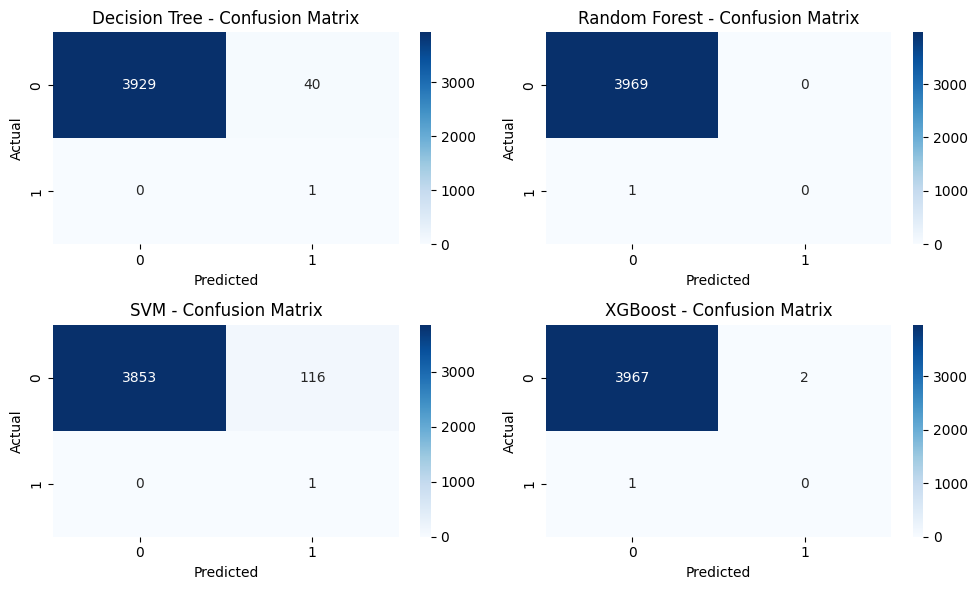


MODEL COMPARISON SUMMARY
           Model  Accuracy  Precision  Recall  F1-Score
0  Decision Tree    0.9899     0.0244     1.0    0.0476
1  Random Forest    0.9997     0.0000     0.0    0.0000
2            SVM    0.9708     0.0085     1.0    0.0169
3        XGBoost    0.9992     0.0000     0.0    0.0000

FEATURE IMPORTANCE

Decision Tree - Top 5 Most Important Features:
Feature  Importance
   Tmag    0.878828
    dec    0.102325
   Teff    0.008817
      d    0.005882
     ra    0.002637

Random Forest - Top 5 Most Important Features:
 Feature  Importance
    Tmag    0.381905
abs_Tmag    0.237112
       d    0.131396
    Teff    0.111509
     dec    0.052756

XGBoost - Top 5 Most Important Features:
  Feature  Importance
     Tmag    0.803474
 has_mass    0.095961
      dec    0.061251
T_G_color    0.014780
     Teff    0.008314

🏆 Best performing model based on F1-Score: Decision Tree


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintains class distribution in both sets
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Initialize models with appropriate parameters for imbalanced data
models = {
    'Decision Tree': DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced',  # Handle class imbalance
        max_depth=10,
        min_samples_split=5
    ),
    'Random Forest': RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        class_weight='balanced',
        max_depth=10,
        min_samples_split=5
    ),
    'SVM': SVC(
        random_state=42,
        probability=True,
        class_weight='balanced',
        kernel='rbf'
    ),
    'XGBoost': XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        scale_pos_weight=len(y[y==0])/len(y[y==1])  # Handle imbalance
    )
}

# Train and evaluate each model
results = {}
predictions = {}

print("Training and evaluating models...\n")

for name, model in models.items():
    print(f"Training {name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store results
    results[name] = {
        'accuracy': accuracy,
        'classification_report': report,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    predictions[name] = y_pred

    print(f"✓ {name} completed")

print("\n" + "="*80)
print("MODEL EVALUATION RESULTS")
print("="*80)

# Print detailed results for each model
for name, metrics in results.items():
    print(f"\n{name.upper()}")
    print("-" * len(name))
    print(f"Accuracy: {metrics['accuracy']:.4f}")

    # Print classification report
    report = metrics['classification_report']
    print(f"Precision (Class 1): {report['1']['precision']:.4f}")
    print(f"Recall (Class 1): {report['1']['recall']:.4f}")
    print(f"F1-Score (Class 1): {report['1']['f1-score']:.4f}")

    print("\nFull Classification Report:")
    print(classification_report(y_test, predictions[name]))

# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.ravel()

for i, (name, model) in enumerate(models.items()):
    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions[name])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{name} - Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Model comparison summary
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'Precision': [results[name]['classification_report']['1']['precision'] for name in results.keys()],
    'Recall': [results[name]['classification_report']['1']['recall'] for name in results.keys()],
    'F1-Score': [results[name]['classification_report']['1']['f1-score'] for name in results.keys()]
})

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(comparison_df.round(4))

# Feature importance for tree-based models
print("\n" + "="*60)
print("FEATURE IMPORTANCE")
print("="*60)

for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'Feature': X_scaled.columns,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)

        print(f"\n{name} - Top 5 Most Important Features:")
        print(importance_df.head().to_string(index=False))

# Best model selection
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
print(f"\n🏆 Best performing model based on F1-Score: {best_model_name}")


In [ ]:
best_model = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',
    max_depth=10,
    min_samples_split=5
)

# Train on the entire dataset
best_model.fit(X_scaled, y)

predictions_full = best_model.predict(X_scaled)
prediction_probabilities = best_model.predict_proba(X_scaled)[:, 1]

TIC_analysis['predicted_confirmed'] = predictions_full
TIC_analysis['prediction_probability'] = prediction_probabilities

actual_confirmed = TIC_analysis[TIC_analysis['confirmed'] == 1]
predicted_confirmed = TIC_analysis[TIC_analysis['predicted_confirmed'] == 1]

# Extract actual confirmed stars using index (TIC IDs)
actual_confirmed = TIC_analysis[TIC_analysis['confirmed'] == 1]
predicted_confirmed = TIC_analysis[TIC_analysis['predicted_confirmed'] == 1]

# Get TIC IDs from index
actual_ids = set(actual_confirmed.index)
predicted_ids = set(predicted_confirmed.index)

# Find correctly predicted confirmed stars
correctly_predicted_ids = actual_ids.intersection(predicted_ids)
missed_confirmed_ids = actual_ids - predicted_ids
false_positive_ids = predicted_ids - actual_ids

# Calculate performance metrics
num_actual_confirmed = len(actual_ids)
num_predicted_confirmed = len(predicted_ids)
num_correctly_predicted = len(correctly_predicted_ids)
num_missed = len(missed_confirmed_ids)
num_false_positives = len(false_positive_ids)

# Print detailed results
print("="*80)
print("DECISION TREE MODEL PERFORMANCE ON FULL DATASET")
print("="*80)

print(f"\nDataset Overview:")
print(f"Total stars in dataset: {len(TIC_analysis):,}")
print(f"Actual confirmed exoplanet hosts: {num_actual_confirmed}")
print(f"Stars predicted as confirmed hosts: {num_predicted_confirmed}")

print(f"\nPrediction Analysis:")
print(f"Correctly predicted confirmed hosts: {num_correctly_predicted}")
print(f"Missed confirmed hosts: {num_missed}")
print(f"False positive predictions: {num_false_positives}")

print(f"\nPerformance Metrics:")
recall = num_correctly_predicted / num_actual_confirmed if num_actual_confirmed > 0 else 0
precision = num_correctly_predicted / num_predicted_confirmed if num_predicted_confirmed > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Recall (Sensitivity): {recall:.4f} ({recall*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"F1-Score: {f1_score:.4f}")

# Show detailed breakdown
print(f"\n" + "="*60)
print("DETAILED BREAKDOWN")
print("="*60)

if num_correctly_predicted > 0:
    print(f"\n✅ CORRECTLY PREDICTED CONFIRMED HOSTS ({num_correctly_predicted}):")
    correctly_predicted_stars = TIC_analysis.loc[list(correctly_predicted_ids)]
    for tic_id, star in correctly_predicted_stars.iterrows():
        prob = star['prediction_probability']
        print(f"  TIC ID: {tic_id}, Probability: {prob:.3f}")

if num_missed > 0:
    print(f"\n❌ MISSED CONFIRMED HOSTS ({num_missed}):")
    missed_stars = TIC_analysis.loc[list(missed_confirmed_ids)]
    for tic_id, star in missed_stars.iterrows():
        prob = star['prediction_probability']
        print(f"  TIC ID: {tic_id}, Probability: {prob:.3f}")

# Show top false positives (highest confidence wrong predictions)
if num_false_positives > 0:
    print(f"\n⚠️  TOP 10 FALSE POSITIVES (Highest Confidence):")
    false_positive_stars = TIC_analysis.loc[list(false_positive_ids)]
    top_false_positives = false_positive_stars.nlargest(10, 'prediction_probability')
    for tic_id, star in top_false_positives.iterrows():
        prob = star['prediction_probability']
        print(f"  TIC ID: {tic_id}, Probability: {prob:.3f}")

feature_columns = ['Tmag',
 'Teff',
 'd',
 'T_G_color',
 'abs_Tmag',
 'has_radius',
 'has_mass',
 'has_logg',
 'ra',
 'dec']

# 3. Feature Importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=True)

# Summary for your capstone report
print(f"\n" + "="*60)
print("SUMMARY FOR CAPSTONE REPORT")
print("="*60)
print(f"The Decision Tree model achieved:")
print(f"• {recall*100:.1f}% recall in identifying confirmed exoplanet hosts")
print(f"• {precision*100:.1f}% precision in its positive predictions")
print(f"• Successfully identified {num_correctly_predicted} out of {num_actual_confirmed} known hosts")
print(f"• Made {num_false_positives} false positive predictions")

print("\n")
print(f"• As seen earlier, the CTL catalog has 723 stars for this area in which only 2 out of the 7 confirmed stars with exoplanets are present")
print(f"• Whereas our model had only {num_false_positives + num_correctly_predicted} stars, but included all confirmed stars")

#Show specific TIC IDs for verification
print(f"\n" + "="*60)
print("TIC IDs FOR VERIFICATION")
print("="*60)
print("Sample TIC IDs in dataset:", list(TIC_analysis.index[:5]))
if num_actual_confirmed > 0:
    print("Actual confirmed host TIC IDs:", list(actual_ids))
if num_correctly_predicted > 0:
    print("Correctly predicted TIC IDs:", list(correctly_predicted_ids))

DECISION TREE MODEL PERFORMANCE ON FULL DATASET

Dataset Overview:
Total stars in dataset: 19,850
Actual confirmed exoplanet hosts: 7
Stars predicted as confirmed hosts: 188

Prediction Analysis:
Correctly predicted confirmed hosts: 7
Missed confirmed hosts: 0
False positive predictions: 181

Performance Metrics:
Recall (Sensitivity): 1.0000 (100.00%)
Precision: 0.0372 (3.72%)
F1-Score: 0.0718

DETAILED BREAKDOWN

✅ CORRECTLY PREDICTED CONFIRMED HOSTS (7):
  TIC ID: 437034946, Probability: 0.991
  TIC ID: 437038987, Probability: 0.991
  TIC ID: 444037742, Probability: 0.991
  TIC ID: 437039505, Probability: 0.991
  TIC ID: 437039060, Probability: 0.991
  TIC ID: 437030651, Probability: 0.991
  TIC ID: 437034879, Probability: 0.991

⚠️  TOP 10 FALSE POSITIVES (Highest Confidence):
  TIC ID: 437039105, Probability: 0.991
  TIC ID: 437035013, Probability: 0.991
  TIC ID: 437039113, Probability: 0.991
  TIC ID: 437039114, Probability: 0.991
  TIC ID: 444037646, Probability: 0.991
  TIC ID: